In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rc

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
sns.set_style('whitegrid')

In [3]:
model_df = pd.read_csv('model-ems.csv')
model_df['group'] = model_df.composer + '\n$\it{' + model_df.line_type + '}$'
group_order = [
    'PD-16K\n$\it{inproject}$',
    'PD-16K\n$\it{infile}$',
    'FL-16K\n$\it{inproject}$',
    'FL-16K\n$\it{infile}$',
]
model_df['group'] = pd.Categorical(model_df['group'], categories=group_order, ordered=True)
model_df = model_df.sort_values(by='group')

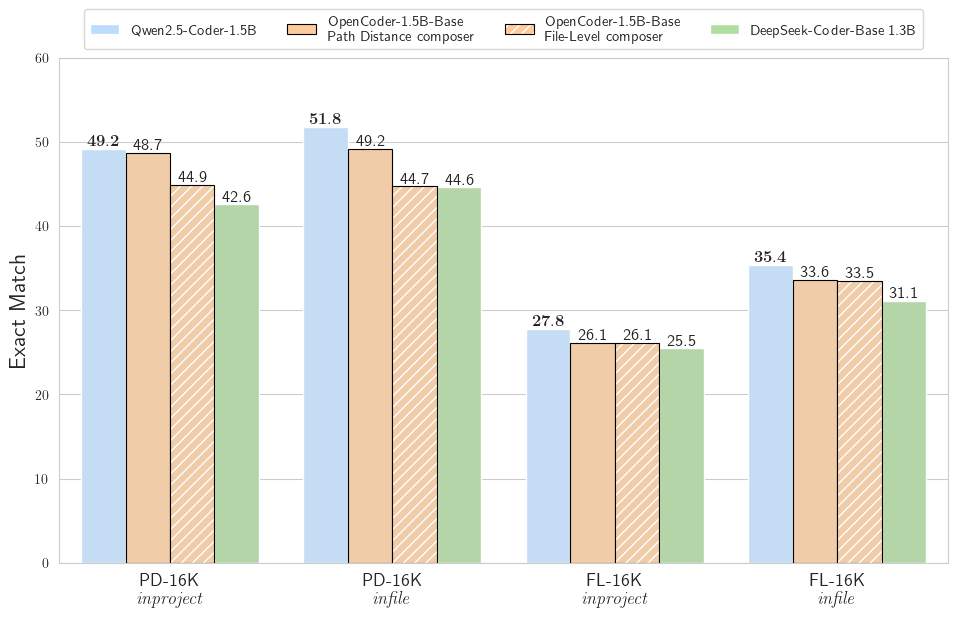

In [4]:
bar_names = {
    'Qwen2.5-Coder-1.5B': 'Qwen2.5-Coder-1.5B',
    'OpenCoder-1.5B-Base (PD)': 'OpenCoder-1.5B-Base\nPath Distance composer',
    'OpenCoder-1.5B-Base (FL)': 'OpenCoder-1.5B-Base\nFile-Level composer',
    'DeepSeek-Coder-Base 1.3B': 'DeepSeek-Coder-Base 1.3B',
}
legend_order = [
    'Qwen2.5-Coder-1.5B',
    'OpenCoder-1.5B-Base (PD)',
    'OpenCoder-1.5B-Base (FL)',
    'DeepSeek-Coder-Base 1.3B',
]
bar_order = legend_order

plt.figure(figsize=(10,6.25))

colors = {
    'DeepSeek-Coder-Base 1.3B': '#b1dd9f',
    'Qwen2.5-Coder-1.5B': '#bcdcfc', 
    'OpenCoder-1.5B-Base (FL)': '#fccc9c',
    'OpenCoder-1.5B-Base (PD)': '#fccc9c',
}

hatches = {
    'DeepSeek-Coder-Base 1.3B': '',
    'Qwen2.5-Coder-1.5B': '',
    'OpenCoder-1.5B-Base (FL)': '///',
    'OpenCoder-1.5B-Base (PD)': '',
}

model_df['model'] = pd.Categorical(model_df['model'], categories=bar_order, ordered=True)
model_df = model_df.sort_values(['group', 'model'])

plot_order = bar_order.copy()
fl_index = plot_order.index('OpenCoder-1.5B-Base (FL)')
ds_index = plot_order.index('DeepSeek-Coder-Base 1.3B')
if fl_index < ds_index:
    plot_order[fl_index], plot_order[ds_index] = plot_order[ds_index], plot_order[fl_index]

ax = sns.barplot(
    x='group', 
    y='exact_match', 
    hue='model', 
    data=model_df,
    palette=colors,
    errorbar=None,
    hue_order=bar_order,
)

for i, bar_container in enumerate(ax.containers):
    model = bar_order[i]
    if model not in ['OpenCoder-1.5B-Base (PD)', 'OpenCoder-1.5B-Base (FL)']:
        for bar in bar_container:
            bar.set_hatch(hatches[model])

for i, bar_container in enumerate(ax.containers):
    model = bar_order[i]
    if model in ['OpenCoder-1.5B-Base (PD)', 'OpenCoder-1.5B-Base (FL)']:
        for bar in bar_container:
            bar.set_hatch(hatches[model])
            bar.set_edgecolor('black')
            bar._hatch_color = (1.0, 1.0, 1.0, 1.0)
            bar.set_linewidth(0.8)
            bar.set_zorder(10)

group_max_values = {}
for group in group_order:
    group_data = model_df[model_df['group'] == group]
    group_max_values[group] = group_data['exact_match'].max()

for i, container in enumerate(ax.containers):
    model = bar_order[i]
    values = [p.get_height() for p in container]
    
    formatted_labels = []
    for j, val in enumerate(values):
        group = model_df['group'].unique()[j]
        if val == group_max_values[group]:
            formatted_labels.append(f"$\\mathbf{{{val:.1f}}}$")
        else:
            formatted_labels.append(f"{val:.1f}")
    
    ax.bar_label(container, fontsize=12, labels=formatted_labels)

plt.xlabel('')
plt.ylabel('Exact Match', fontsize=16)
plt.ylim(0, 60)

plt.xticks(fontsize=13)

ax.get_legend().remove()

custom_handles = []
for model in legend_order:
    patch = mpatches.Patch(
        facecolor=colors[model],
        hatch=hatches[model],
        label=bar_names[model],
        edgecolor='black' if model in ['OpenCoder-1.5B-Base (PD)', 'OpenCoder-1.5B-Base (FL)'] else None,
        linewidth=0.8 if model in ['OpenCoder-1.5B-Base (PD)', 'OpenCoder-1.5B-Base (FL)'] else None,
    )
    patch._hatch_color = (1.0, 1.0, 1.0, 1.0)
    custom_handles.append(patch)

plt.legend(
    handles=custom_handles,
    title='',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.11),
    ncol=len(legend_order),
    fontsize=10.5,
)

plt.tight_layout()

plt.savefig('model-comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('model-comparison.svg', format='svg', bbox_inches='tight')